# Time series: obtener datos

In [ ]:
!pip install osmnx
!pip install sklearn
!pip install matplotlib==3.1.3

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import networkx as nx 
import math
import matplotlib.pyplot as plt 
import osmnx as ox
import pandas as pandas
import matplotlib.colors as mcolors

# for Notebook
%matplotlib inline

In [4]:
data = pandas.read_csv("/content/drive/MyDrive/Colab Notebooks/cleaned-sorted-torino.csv")   

In [5]:
## EXTRAEMOS DATOS DEL FICHERO DE TIME SERIES
data_reduced = data.loc[:, ['Road_LCD', 'lat', 'lng','speed']]              ## COGEMOS SOLO ID, LATITUD Y LONGITUD DE MOMENTO
#print(data.dtypes)                                                ## IMPRIMIMOS LAS CABECERAS QUE HAY EN EL FICHERO
#data_reduced.head()
total_ID_TS = data_reduced.groupby('Road_LCD')['lat'].nunique()  ## OBTENEMOS EL NUMERO DE REPETICIONS DE CADA ELEMENTO
ID_TS = data_reduced['Road_LCD'].unique().tolist()               ## OBTENEMOS LISTA DE LOS ID'S UNICOS
# print(ID_TS)
# print(len(total_ID_TS), "different IDs")                       ## NUMERO DE ID DIFERENTES
ID_TS_UNIQUE = data_reduced.drop_duplicates(['Road_LCD'], keep='last') ## LISTA DE NODOS FILTRADOS
#print(ID_TS_UNIQUE)


# Grafo Turin inicial: crear mapa y filtrar. 

In [6]:
place_name = "Torino, Italy"
highway_filter = '["highway"~"trunk|motorway|primary|secondary"]'
# map           = ox.graph_from_place(place_name, network_type="drive") MAPA SIN FILTRAR
map_filtered = ox.graph_from_place(place_name, network_type="drive"
                                   ,custom_filter=highway_filter)        ## FILTRAR GRAFO DE TURIN
# print(len(map_filtered), "nodes of motorway and primary")                ## IMPRIMIR NUMERO TOTAL DE CARRETERAS
#fig, ax = ox.plot_graph(map_filtered, node_color="r")                    ## IMPRIMIR GRAFO DE TURIN FILTRADO
#ox.plot_graph_folium(map_filtered, popup_attribute='name',
                     #color='red', weight=2, opacity=0.7)
# ox.save_graph_geopackage(map_filtered, filepath="torino.gpkg")         ## GUARDAR GRAFO TURIN EN FORMATO GPKG

In [7]:
map_data_long = pandas.DataFrame(map_filtered.nodes(data = 'x'), columns=['ID', 'lng'])
map_data_lat = pandas.DataFrame(map_filtered.nodes(data = 'y'), columns=['ID', 'lat'])
map_data_sc = pandas.DataFrame(map_filtered.nodes(data = 'street_count'), columns=['ID', 'street_count'])
map_data_turin = pandas.merge(map_data_lat, map_data_long, on='ID')      ## DATAFRAME CON ID, LAT Y LONG DE LOS NODOS DE TURIN
map_data_turin = pandas.merge(map_data_turin, map_data_sc, on='ID')      ## DATAFRAME CON ID, LAT Y LONG DE LOS NODOS DE TURIN
print(map_data_turin)


             ID        lat       lng  street_count
0       5654262  45.134580  7.715359             3
1      13924308  45.077624  7.669412             4
2      13924314  45.087838  7.690744             3
3      13924319  45.091656  7.654505             3
4      13924332  45.091868  7.693590             3
..          ...        ...       ...           ...
694  9697397406  45.022892  7.634542             3
695  9697397407  45.022793  7.635497             3
696  9697397408  45.022834  7.635507             3
697  9697397413  45.023134  7.634721             3
698  9697397416  45.023097  7.634671             3

[699 rows x 4 columns]


In [ ]:
print(map_filtered.nodes(data=True))

[(5654262, {'y': 45.1345798, 'x': 7.7153588, 'street_count': 3}), (13924308, {'y': 45.0776239, 'x': 7.6694124, 'street_count': 4}), (13924314, {'y': 45.0878377, 'x': 7.690744, 'street_count': 3}), (13924319, {'y': 45.0916559, 'x': 7.6545052, 'street_count': 3}), (13924332, {'y': 45.0918681, 'x': 7.6935903, 'street_count': 3}), (13929739, {'y': 45.076578, 'x': 7.6681246, 'street_count': 3}), (13929741, {'y': 45.0753519, 'x': 7.6436376, 'street_count': 3}), (13929742, {'y': 45.0584708, 'x': 7.6907576, 'highway': 'traffic_signals', 'street_count': 3}), (13929743, {'y': 45.0645083, 'x': 7.6739893, 'street_count': 3}), (13929752, {'y': 45.0672875, 'x': 7.6662182, 'street_count': 4}), (13929763, {'y': 45.069119, 'x': 7.706575, 'street_count': 3}), (13929782, {'y': 45.0583373, 'x': 7.6658891, 'street_count': 4}), (13966518, {'y': 45.0595227, 'x': 7.6878346, 'street_count': 3}), (13990544, {'y': 45.0464859, 'x': 7.6577642, 'street_count': 3}), (13990620, {'y': 45.057209, 'x': 7.6687955, 'stree

# Algoritmo ML I: Calcular el nodo mas cercano e imprimir

In [8]:
df = data_reduced.drop_duplicates('Road_LCD')

In [9]:
matriz_final2 = pandas.DataFrame() 

#Calculamos los nodos más cercanos y les asignamos un Road_LCD
for i in range(0,42):
        matriz_final2.at[i, "Nodo"] = ox.distance.nearest_nodes(map_filtered, X= df['lng'].values[i], Y= df['lat'].values[i])
        matriz_final2.at[i, "Road_LCD"] = df['Road_LCD'].values[i]

#Buscamos en esa lista las coincidencias y les damos sus atributos
for i in range(0,42):
  for j in range (0,699):
    if map_data_turin['ID'].values[j] == matriz_final2['Nodo'].values[i]:
       matriz_final2.at[i, "Lat"] = map_data_turin['lat'].values[j]
       matriz_final2.at[i, "Long"] = map_data_turin['lng'].values[j]
       matriz_final2.at[i, "street_count"] = map_data_turin['street_count'].values[j]
    else:
      pass

#En caso de que dos nodos coincidan con el mismo, lo eliminamos
matriz_final2 = matriz_final2.drop_duplicates('Nodo')
matriz_final2.index = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,
                              21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38]
print(matriz_final2)


            Nodo  Road_LCD        Lat      Long  street_count
0   2.957320e+08   39975.0  45.023620  7.636258           3.0
1   7.698723e+08   39985.0  45.070837  7.727213           3.0
2   9.450170e+08   40000.0  45.034618  7.642993           4.0
3   1.168930e+09   40013.0  45.060027  7.661493           4.0
4   4.506091e+08   40017.0  45.074269  7.614475           3.0
5   4.294936e+08   40029.0  45.039797  7.653124           3.0
6   4.445949e+08   40036.0  45.032684  7.646403           4.0
7   1.311009e+09   40039.0  45.118350  7.710710           3.0
8   4.344988e+08   40052.0  45.049992  7.653865           3.0
9   1.262044e+09   40055.0  45.073156  7.641508           3.0
10  6.164814e+08   40062.0  45.017485  7.667013           3.0
11  1.396652e+07   40066.0  45.059523  7.687835           3.0
12  1.392431e+07   40088.0  45.087838  7.690744           3.0
13  2.636943e+08   40093.0  45.031128  7.612158           3.0
14  3.040660e+07   40102.0  45.062134  7.656062           4.0
15  9.15

In [ ]:
matriz_final2.head()

,Nodo,Road_LCD,Lat,Long,street_count
0,2.957320e+08,39975.0,45.023620,7.636258,3.0
1,7.698723e+08,39985.0,45.070837,7.727213,3.0
2,9.450170e+08,40000.0,45.034618,7.642993,4.0
3,1.168930e+09,40013.0,45.060027,7.661493,4.0
4,4.506091e+08,40017.0,45.074269,7.614475,3.0


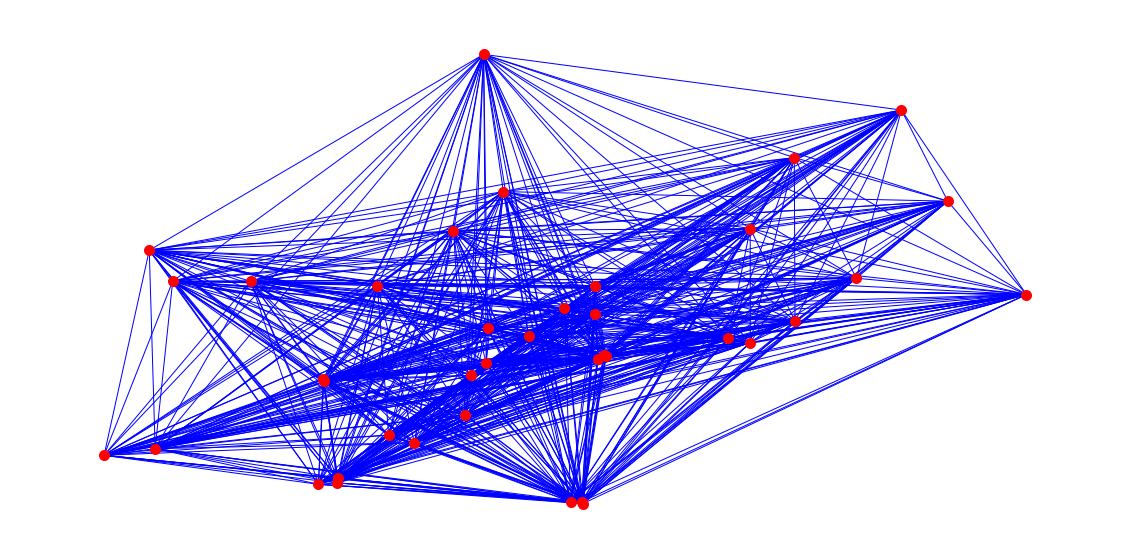

In [10]:
G_full=nx.Graph()

for i in range(0,39):
  for j in range(0,39):
    if i == j:
      pass
    else:
      id1 = matriz_final2['Road_LCD'].values[i]
      id2 = matriz_final2['Road_LCD'].values[j]
      d = ox.distance.great_circle_vec(matriz_final2['Lat'].values[i], matriz_final2['Long'].values[i], matriz_final2['Lat'].values[j], matriz_final2['Long'].values[j])
      d_km = d/1000
      G_full.add_edge(id1,id2, weight = d_km )
    
pos = {}
for i in range(0,39):
  pos[matriz_final2['Road_LCD'].values[i]] = (matriz_final2['Long'].values[i],matriz_final2['Lat'].values[i])

fig, ax = plt.subplots(figsize = (20,10))

nx.draw( G_full,
        pos = pos,
        node_color = 'r',
        edge_color = 'b',
        font_size = 10,
        node_size = 100)



#guardar G en uno de los formatos de aquí https://networkx.org/documentation/stable/reference/readwrite/index.html


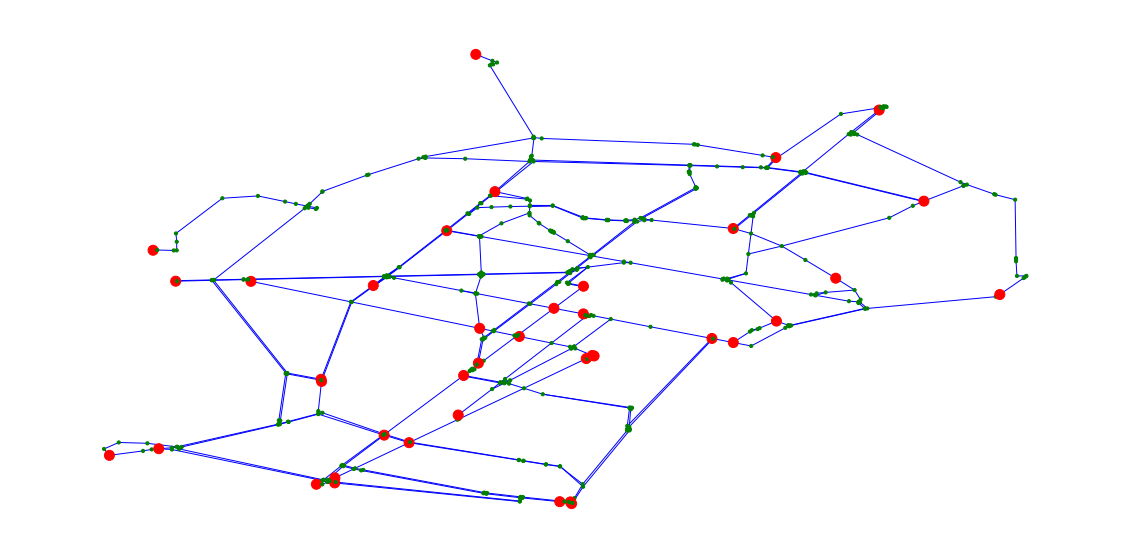

In [11]:
G_full1=nx.Graph()
routes = []

for i in range(0,39):
  for j in range(i,39):
    if i == j:
      pass
    else:
      orig1 = matriz_final2['Nodo'].values[i]
      dest1 = matriz_final2['Nodo'].values[j]
      route1 = ox.shortest_path(map_filtered, orig1, dest1, weight = "length") 
      routes.append(route1)
      if route1 == None:
        pass
      else:
        for k in range(0,len(route1)):
          if k == len(route1)-1:
            pass
          else:
            id1 = route1[k]
            id2 = route1[k+1]
            C = map_data_turin.index[map_data_turin['ID'] == id1].tolist()
            D = map_data_turin.index[map_data_turin['ID'] == id2].tolist()
            pos1 = C[0]
            pos2 = D[0]
            dist = ox.distance.great_circle_vec(map_data_turin['lat'].values[C], map_data_turin['lng'].values[C], map_data_turin['lat'].values[D], map_data_turin['lng'].values[D])
            dist_km = dist[0]/1000
            G_full1.add_edge(id1,id2, weight = dist_km)

pos = {}
for i in range(0,39):
  pos[matriz_final2['Nodo'].values[i]] = (matriz_final2['Long'].values[i],matriz_final2['Lat'].values[i])

color_map = []
node_size_map = []

for node in G_full1:
  l = 0
  for i in range(0,39):
    if node == matriz_final2['Nodo'].values[i]:
      l = l + 1
    else:
      l = l + 0
  if l == 1:
    color_map.append('red')
    node_size_map.append(100)
  else: 
    color_map.append('green')  
    node_size_map.append(10) 

pos = {}
for i in range(0,699):
  pos[map_data_turin['ID'].values[i]] = (map_data_turin['lng'].values[i],map_data_turin['lat'].values[i])

fig, ax = plt.subplots(figsize = (20,10))

nx.draw( G_full1,
        pos = pos,
        node_color = color_map,
        edge_color = 'b',
        font_size = 10,
        node_size = node_size_map
)

In [ ]:
print(G_full1)

Graph with 470 nodes and 627 edges


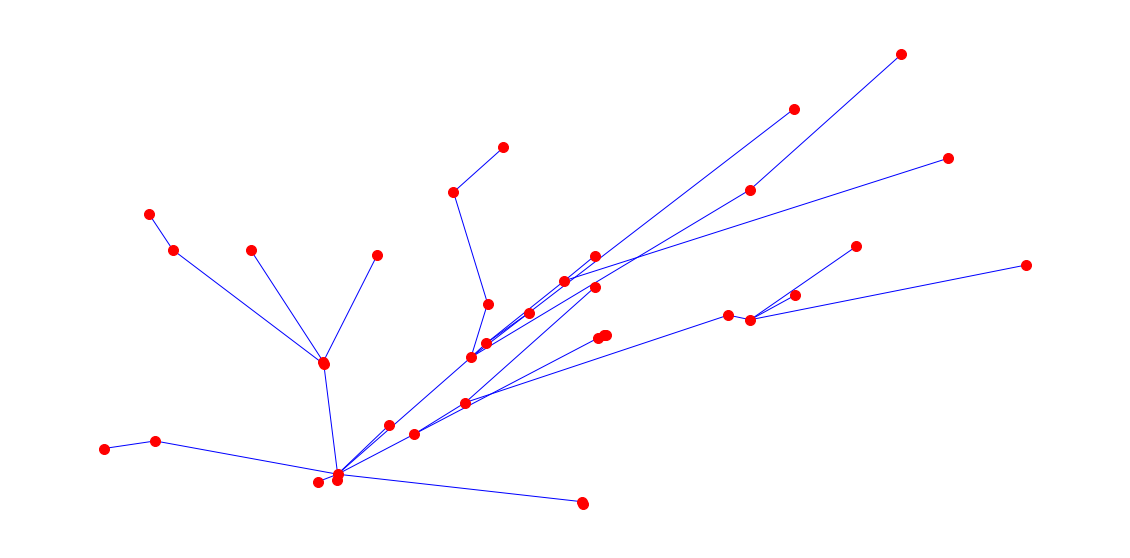

In [12]:
G_full2=nx.Graph()

for i in range(0,39):
  for j in range(0,39):
    if i == j:
      pass
    else:
      orig1 = matriz_final2['Nodo'].values[i]
      dest1 = matriz_final2['Nodo'].values[j]
      route1 = ox.shortest_path(map_filtered, orig1, dest1, weight = "length") 
      routes.append(route1)
      if route1 == None:
        pass
      else:
        b = 0
        for k in range(0,len(route1)):
          if k == len(route1)-1:
            pass
          else:
              a = 0
              for i in range(0,39):
                if route1[k+1] == matriz_final2['Nodo'].values[i]:
                  a = a + 1
                else:
                  a = a + 0
              if a == 1:
                id1 = route1[k-b]
                id2 = route1[k+1]
                C = map_data_turin.index[map_data_turin['ID'] == id1].tolist()
                D = map_data_turin.index[map_data_turin['ID'] == id2].tolist()
                pos1 = C[0]
                pos2 = D[0]
                dist = ox.distance.great_circle_vec(map_data_turin['lat'].values[C], map_data_turin['lng'].values[C], map_data_turin['lat'].values[D], map_data_turin['lng'].values[D])
                dist_km = dist[0]/1000
                G_full2.add_edge(id1,id2, weight = dist_km)
                b = 0
              else:
                b = b + 1 
                pass 

pos = {}
for i in range(0,699):
  pos[map_data_turin['ID'].values[i]] = (map_data_turin['lng'].values[i],map_data_turin['lat'].values[i])

fig, ax = plt.subplots(figsize = (20,10))

nx.draw( G_full2,
        pos = pos,
        node_color = 'r',
        edge_color = 'b',
        font_size = 10,
        node_size = 100
)



In [13]:
print(nx.clustering(G_full2)) 

{295732036.0: 0, 444594932: 0, 429493617: 0, 13966518: 0, 13929742: 0, 769872294.0: 0, 945016953.0: 0, 1168929657.0: 0, 444026921: 0, 434498834: 0, 450609061.0: 0, 5328998451: 0, 1311008607.0: 0, 13924314: 0, 1262044113.0: 0, 5328998474: 0, 263694269.0: 0, 30406599.0: 0, 915327085.0: 0, 642267255: 0, 3273458421.0: 0, 1628116962.0: 0, 7054181489: 0, 8274593262: 0, 444026992.0: 0, 444026981: 0, 295732031.0: 0, 442195354.0: 0, 13929752.0: 0, 442330082.0: 0, 537744926.0: 0, 246508623.0: 0, 61875832.0: 0, 28807262.0: 0, 1037151316.0: 0, 299805842.0: 0, 354689889.0: 0}


In [14]:
print(G_full2.edges(data=True))

[(295732036.0, 444594932, {'weight': 1.2851076319806185}), (295732036.0, 945016953.0, {'weight': 1.3325918513553094}), (295732036.0, 434498834, {'weight': 3.242381968405808}), (295732036.0, 5328998451, {'weight': 2.765263039127846}), (295732036.0, 263694269.0, {'weight': 2.069792575889641}), (295732036.0, 444026981, {'weight': 2.624034608710151}), (295732036.0, 295732031.0, {'weight': 0.2712798475326166}), (295732036.0, 1037151316.0, {'weight': 0.1441161088042627}), (444594932, 429493617, {'weight': 0.9510498022101344}), (444594932, 8274593262, {'weight': 3.0707892202960103}), (429493617, 13966518, {'weight': 3.4994913116415445}), (429493617, 442330082.0, {'weight': 3.1937425523140357}), (13966518, 13929742, {'weight': 0.25766711908148243}), (13929742, 769872294.0, {'weight': 3.176254248325891}), (13929742, 3273458421.0, {'weight': 0.7694429099138006}), (13929742, 246508623.0, {'weight': 2.1460159872257503}), (1168929657.0, 444026921, {'weight': 0.8808333254618076}), (444026921, 434498

In [15]:
print(G_full2)

Graph with 37 nodes and 36 edges


In [16]:
caminos = list(G_full2.edges(data='weight'))
caminos_final =pandas.DataFrame(caminos)
print(caminos_final)

               0             1         2
0   2.957320e+08  4.445949e+08  1.285108
1   2.957320e+08  9.450170e+08  1.332592
2   2.957320e+08  4.344988e+08  3.242382
3   2.957320e+08  5.328998e+09  2.765263
4   2.957320e+08  2.636943e+08  2.069793
5   2.957320e+08  4.440270e+08  2.624035
6   2.957320e+08  2.957320e+08  0.271280
7   2.957320e+08  1.037151e+09  0.144116
8   4.445949e+08  4.294936e+08  0.951050
9   4.445949e+08  8.274593e+09  3.070789
10  4.294936e+08  1.396652e+07  3.499491
11  4.294936e+08  4.423301e+08  3.193743
12  1.396652e+07  1.392974e+07  0.257667
13  1.392974e+07  7.698723e+08  3.176254
14  1.392974e+07  3.273458e+09  0.769443
15  1.392974e+07  2.465086e+08  2.146016
16  1.168930e+09  4.440269e+08  0.880833
17  4.440269e+08  4.344988e+08  0.387197
18  4.440269e+08  1.392975e+07  1.767428
19  4.344988e+08  1.392431e+07  5.108590
20  4.344988e+08  3.040660e+07  1.361111
21  4.344988e+08  4.421954e+08  7.083239
22  4.506091e+08  5.328998e+09  3.270416
23  4.506091e+08

# Algoritmos ML II: Centralidad

In [ ]:
def draw(G, pos, measures, measure_name):
    
    nodes = nx.draw_networkx_nodes(G, pos, node_size=250, cmap=plt.cm.plasma, 
                                   node_color=list(measures.values()),
                                   nodelist=measures.keys())
    nodes.set_norm(mcolors.SymLogNorm(linthresh=0.01, linscale=1, base=10))
    # labels = nx.draw_networkx_labels(G, pos)
    edges = nx.draw_networkx_edges(G, pos)

    plt.title(measure_name)
    plt.colorbar(nodes)
    plt.axis('off')
    plt.show()

pos = nx.spring_layout(G_full2, seed=675)

In [ ]:
# Centralidad intermediación 
pandas.DataFrame.from_dict(nx.algorithms.centrality.betweenness_centrality(G_full2), 
                       orient='index', 
                       columns = ['Centralidad de Intermediación'])\
            .sort_values(['Centralidad de Intermediación'], 
                         ascending = False)\
            .head(10)

,Centralidad de Intermediación
2.957320e+08,0.780952
4.344988e+08,0.501587
4.445949e+08,0.446032
4.294936e+08,0.293651
5.328998e+09,0.255556
4.440269e+08,0.207937
1.396652e+07,0.203175
1.392974e+07,0.161905
5.328998e+09,0.109524
1.392975e+07,0.109524


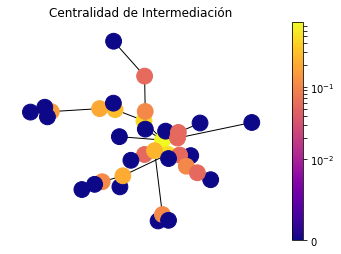

In [ ]:
draw(G_full2, pos, nx.betweenness_centrality(G_full2), 'Centralidad de Intermediación')

In [ ]:
# closeness_centrality
pandas.DataFrame.from_dict(nx.algorithms.centrality.closeness_centrality(G_full2), 
                       orient='index', 
                       columns = ['Centralidad de cercanía'])\
            .sort_values(['Centralidad de cercanía'], 
                         ascending = False)\
            .head(10)

,Centralidad de cercanía
2.957320e+08,0.387097
4.344988e+08,0.339623
4.445949e+08,0.333333
5.328998e+09,0.305085
2.636943e+08,0.285714
4.440270e+08,0.285714
2.957320e+08,0.281250
1.037151e+09,0.281250
9.450170e+08,0.281250
4.294936e+08,0.274809


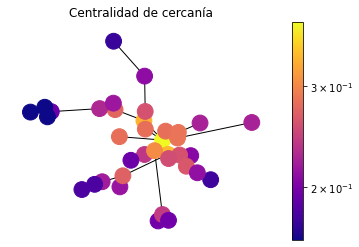

In [ ]:
draw(G_full2, pos, nx.closeness_centrality(G_full2), 'Centralidad de cercanía')

In [ ]:
# degree_centrality
pandas.DataFrame.from_dict(nx.algorithms.centrality.degree_centrality(G_full2), 
                       orient='index', 
                       columns = ['Centralidad de grado'])\
            .sort_values(['Centralidad de grado'], 
                         ascending = False)\
            .head(10)

   

,Centralidad de grado
2.957320e+08,0.222222
4.344988e+08,0.138889
1.392974e+07,0.111111
5.328998e+09,0.083333
4.294936e+08,0.083333
1.392975e+07,0.083333
4.440269e+08,0.083333
4.445949e+08,0.083333
5.328998e+09,0.083333
8.274593e+09,0.055556


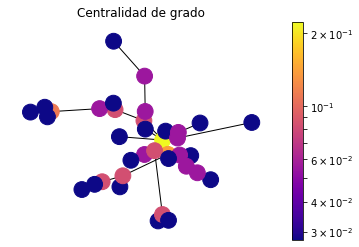

In [ ]:
draw(G_full2, pos, nx.degree_centrality(G_full2), 'Centralidad de grado')

In [ ]:
# eigenvector_centrality 
pandas.DataFrame.from_dict(nx.algorithms.centrality.eigenvector_centrality(G_full2), 
                       orient='index', 
                       columns = ['Centralidad del vector propio'])\
            .sort_values(['Centralidad del vector propio'], 
                         ascending = False)\
            .head(10)

            

,Centralidad del vector propio
2.957320e+08,0.613490
4.344988e+08,0.367904
4.445949e+08,0.261154
5.328998e+09,0.259603
4.440270e+08,0.218900
2.636943e+08,0.218900
2.957320e+08,0.196454
1.037151e+09,0.196454
9.450170e+08,0.196454
4.440269e+08,0.153311


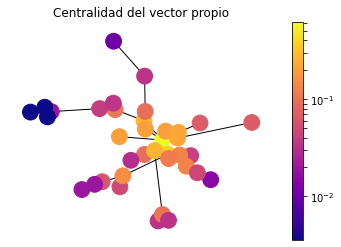

In [ ]:
draw(G_full2, pos, nx.eigenvector_centrality(G_full2), 'Centralidad del vector propio')

In [ ]:
# closeness_centrality 
pandas.DataFrame.from_dict(nx.algorithms.centrality.closeness_centrality(G_full2), 
                       orient='index', 
                       columns = ['Centralidad de cercanía'])\
            .sort_values(['Centralidad de cercanía'], 
                         ascending = False)\
            .head(10)

,Centralidad de cercanía
2.957320e+08,0.387097
4.344988e+08,0.339623
4.445949e+08,0.333333
5.328998e+09,0.305085
2.636943e+08,0.285714
4.440270e+08,0.285714
2.957320e+08,0.281250
1.037151e+09,0.281250
9.450170e+08,0.281250
4.294936e+08,0.274809


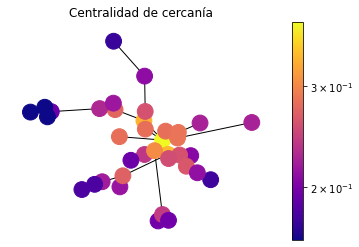

In [ ]:
draw(G_full2, pos, nx.closeness_centrality(G_full2), 'Centralidad de cercanía')

In [ ]:
# Katz Centrality 
pandas.DataFrame.from_dict(nx.algorithms.centrality.katz_centrality(G_full2), 
                       orient='index', 
                       columns = ['Centralidad de Katz'])\
            .sort_values(['Centralidad de Katz'], 
                         ascending = False)\
            .head(10)

,Centralidad de Katz
2.957320e+08,0.267125
4.344988e+08,0.220257
4.445949e+08,0.188156
5.328998e+09,0.187812
1.392974e+07,0.187793
4.440269e+08,0.181564
4.294936e+08,0.177246
5.328998e+09,0.175294
1.392975e+07,0.174657
4.440270e+08,0.168656


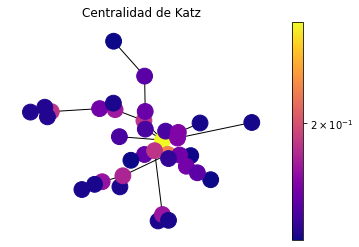

In [ ]:
draw(G_full2, pos, nx.katz_centrality(G_full2, alpha=0.1, beta=1.0), 'Centralidad de Katz')

In [ ]:
print(nx.global_efficiency(G_full))
print(nx.global_efficiency(G_full1))
print(nx.global_efficiency(G_full2))

1.0
0.09248756890347799
0.2933987558987546


In [ ]:
preds = nx.common_neighbor_centrality(G_full2, [(caminos_final[0].values[0], caminos_final[1].values[0])])

for u, v, p in preds:
    print(f"({u}, {v}) -> {p}")

(295732036.0, 444594932.0) -> 7.399999999999999


# Algoritmo ML III: Clustering sobre grafo

In [19]:
from sklearn import preprocessing 
from sklearn.cluster import KMeans
# Importamos las librerias necesarias
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import plotly as py
import plotly.io as pio
import plotly.express as px
from sklearn.cluster import KMeans
from sklearn import preprocessing
from yellowbrick.cluster import KElbowVisualizer
import warnings
from sklearn.cluster import KMeans
from sklearn import preprocessing
import sklearn.cluster as cluster
import sklearn.metrics as metrics
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [33]:
#%% Se normalizan los datos con MinMax()
min_max_scaler = preprocessing.MinMaxScaler() 
df_escalado1 = min_max_scaler.fit_transform(matriz_final2)
df_escalado1 = pd.DataFrame(df_escalado1) # Hay que convertir a DF el resultado.
df_escalado1 = df_escalado1.rename(columns = {0: 'Nodo', 1: 'Road_LCD', 2: 'Lat', 3:'Long',4:'street_count'})
df_escalado1.head()

,Nodo,Road_LCD,Lat,Long,street_count
0,0.034114,0.991645,0.057364,0.253263,0.5
1,0.091512,0.991895,0.465465,1.000000,0.5
2,0.112714,0.992270,0.152424,0.308555,1.0
3,0.139820,0.992595,0.372033,0.460441,1.0
4,0.052863,0.992695,0.495124,0.074426,0.5


In [34]:
K=range(2,12)
wss = []

for k in K:
    kmeans=cluster.KMeans(n_clusters=k)
    kmeans=kmeans.fit(df_escalado1)
    wss_iter = kmeans.inertia_
    wss.append(wss_iter)

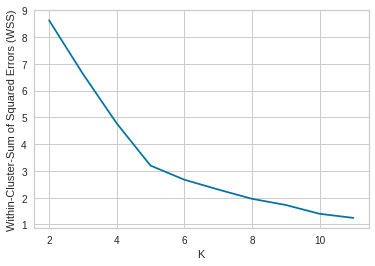

In [35]:
plt.xlabel('K')
plt.ylabel('Within-Cluster-Sum of Squared Errors (WSS)')
plt.plot(K,wss)

In [36]:
import sklearn.cluster as cluster
import sklearn.metrics as metrics
for i in range(2,13):
  labels=cluster.KMeans(n_clusters=i,random_state=200).fit(df_escalado1).labels_
  print ("Silhouette score for k(clusters) = "+str(i)+" is "
  +str(metrics.silhouette_score(df_escalado1,labels,metric="euclidean",sample_size=1000,random_state=200))) 
 

Silhouette score for k(clusters) = 2 is 0.21303275471855448
Silhouette score for k(clusters) = 3 is 0.26703324152989116
Silhouette score for k(clusters) = 4 is 0.3207630224106652
Silhouette score for k(clusters) = 5 is 0.3925493597151987
Silhouette score for k(clusters) = 6 is 0.40059798637872934
Silhouette score for k(clusters) = 7 is 0.42137018280657357
Silhouette score for k(clusters) = 8 is 0.38982881901296895
Silhouette score for k(clusters) = 9 is 0.40679688197299513
Silhouette score for k(clusters) = 10 is 0.36479339277405504
Silhouette score for k(clusters) = 11 is 0.37996173490058505
Silhouette score for k(clusters) = 12 is 0.38539901117797937


In [37]:
# We will use 2 Variables for this example
kmeans = cluster.KMeans(n_clusters=7 ,init="k-means++")
kmeans = kmeans.fit(df_escalado1[['Lat','Long']])

In [38]:
km=KMeans(n_clusters=7)
y_predicted = km.fit_predict(df_escalado1[['Lat','Long']])
y_predicted

array([4, 1, 4, 0, 5, 0, 4, 6, 0, 5, 3, 1, 1, 4, 0, 2, 2, 0, 1, 4, 4, 0,
       3, 0, 4, 3, 6, 0, 0, 6, 1, 1, 0, 5, 0, 4, 4, 5, 2], dtype=int32)

In [39]:
km.cluster_centers_

array([[0.35272961, 0.47875848],
       [0.45203799, 0.77381188],
       [0.76733166, 0.40778592],
       [0.00272168, 0.51419483],
       [0.13480637, 0.21279813],
       [0.5098461 , 0.14469265],
       [0.77323252, 0.84256089]])

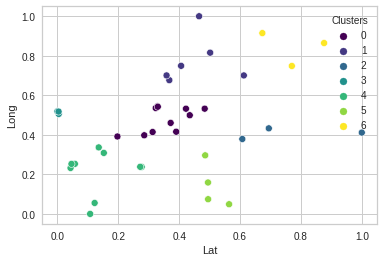

In [41]:
df_escalado1['Clusters'] = km.labels_
sns.scatterplot(x="Lat", y="Long",hue = 'Clusters',  data=df_escalado1,palette='viridis')


(0.0, 1.0)

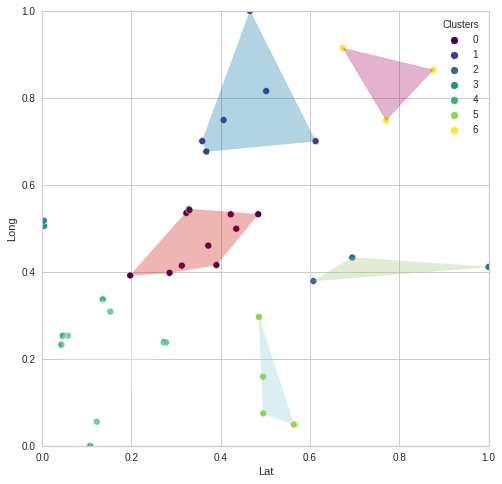

In [46]:
from scipy.spatial import ConvexHull
import numpy as np

fig, ax = plt.subplots(1, figsize=(8,8))
# plot data
sns.scatterplot(x="Lat", y="Long",hue = 'Clusters',  data=df_escalado1,palette='viridis')
color = ['r','b','g','k','w','c','m']
# draw enclosure
for i in df_escalado1.Clusters.unique():
    points = df_escalado1[df_escalado1.Clusters == i][['Lat', 'Long']].values
    # get convex hull
    hull = ConvexHull(points)
    # get x and y coordinates
    # repeat last point to close the polygon
    x_hull = np.append(points[hull.vertices,0],
                       points[hull.vertices,0][0])
    y_hull = np.append(points[hull.vertices,1],
                       points[hull.vertices,1][0])
    # plot shape
    plt.fill(x_hull, y_hull, alpha=0.3, color = color[i])
    
plt.xlim(0,1)
plt.ylim(0,1)

# Algoritmo ML IV: técnicas de Kruskal y Borůvka. Matriz de adyacencia.

## Varios

In [ ]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
from mlxtend.plotting import plot_decision_regions

# Preprocesado y modelado
# ==============================================================================
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Configuración matplotlib
# ==============================================================================
plt.rcParams['image.cmap'] = "bwr"
#plt.rcParams['figure.dpi'] = "100"
plt.rcParams['savefig.bbox'] = "tight"
style.use('ggplot') or plt.style.use('ggplot')

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

In [ ]:
print(matriz_final2)

            Nodo  Road_LCD        Lat      Long  street_count  Numero_asignado
0   2.957320e+08   39975.0  45.023620  7.636258           3.0              0.0
1   7.698723e+08   39985.0  45.070837  7.727213           3.0              1.0
2   9.450170e+08   40000.0  45.034618  7.642993           4.0              2.0
3   1.168930e+09   40013.0  45.060027  7.661493           4.0              3.0
4   4.506091e+08   40017.0  45.074269  7.614475           3.0              4.0
5   4.294936e+08   40029.0  45.039797  7.653124           3.0              5.0
6   4.445949e+08   40036.0  45.032684  7.646403           4.0              6.0
7   1.311009e+09   40039.0  45.118350  7.710710           3.0              7.0
8   4.344988e+08   40052.0  45.049992  7.653865           3.0              8.0
9   1.262044e+09   40055.0  45.073156  7.641508           3.0              9.0
10  6.164814e+08   40062.0  45.017485  7.667013           3.0             10.0
11  1.396652e+07   40066.0  45.059523  7.687835     

In [ ]:
matriz_final2.head()

,Nodo,Road_LCD,Lat,Long,street_count
0,2.957320e+08,39975.0,45.023620,7.636258,3.0
1,7.698723e+08,39985.0,45.070837,7.727213,3.0
2,9.450170e+08,40000.0,45.034618,7.642993,4.0
3,1.168930e+09,40013.0,45.060027,7.661493,4.0
4,4.506091e+08,40017.0,45.074269,7.614475,3.0


In [ ]:
df10 = pandas.DataFrame(caminos)

for i in range(0,39):
    matriz_final2.at[i, "Numero_asignado"] = i

for i in range(0,36):
  id1 = df10[0].values[i]
  id2 = df10[1].values[i]
  C = matriz_final2.index[matriz_final2['Nodo'] == id1].tolist()
  D = matriz_final2.index[matriz_final2['Nodo'] == id2].tolist()
  pos1 = C[0]
  pos2 = D[0]
  if pos2 == 37:
    df10.at[i, "Numero_asignado2"] = 10
    df10.at[i, "Numero_asignado1"] = pos1
  elif pos2 == 36:
    df10.at[i, "Numero_asignado2"] = 1
    df10.at[i, "Numero_asignado1"] = pos1
  else:
    df10.at[i, "Numero_asignado1"] = pos1
    df10.at[i, "Numero_asignado2"] = pos2
print(df10)

               0             1         2  Numero_asignado1  Numero_asignado2
0   2.957320e+08  4.445949e+08  1.285108               0.0               6.0
1   2.957320e+08  9.450170e+08  1.332592               0.0               2.0
2   2.957320e+08  4.344988e+08  3.242382               0.0               8.0
3   2.957320e+08  5.328998e+09  2.765263               0.0              20.0
4   2.957320e+08  2.636943e+08  2.069793               0.0              13.0
5   2.957320e+08  4.440270e+08  2.624035               0.0              25.0
6   2.957320e+08  2.957320e+08  0.271280               0.0              24.0
7   2.957320e+08  1.037151e+09  0.144116               0.0              35.0
8   4.445949e+08  4.294936e+08  0.951050               6.0               5.0
9   4.445949e+08  8.274593e+09  3.070789               6.0              23.0
10  4.294936e+08  1.396652e+07  3.499491               5.0              11.0
11  4.294936e+08  4.423301e+08  3.193743               5.0              28.0

## Minimum Spanning Trees - Borůvka's Algorithm

In [ ]:
class Graph:
    def __init__(self, num_of_nodes):
        self.m_v = num_of_nodes
        self.m_edges = []
        self.m_component = {}
    def add_edge(self, u, v, weight):
        self.m_edges.append([u, v, weight])

    def find_component(self, u):
        if self.m_component[u] == u:
            return u
        return self.find_component(self.m_component[u])

    def set_component(self, u):
        if self.m_component[u] == u:
            return
        else:
            for k in self.m_component.keys():
                self.m_component[k] = self.find_component(k)

    def union(self, component_size, u, v):
          if component_size[u] <= component_size[v]:
              self.m_component[u] = v
              component_size[v] += component_size[u]
              self.set_component(u)

          elif component_size[u] >= component_size[v]:
              self.m_component[v] = self.find_component(u)
              component_size[u] += component_size[v]
              self.set_component(v)

          print(self.m_component)

    def boruvka(self):
            component_size = []
            mst_weight = 0

            minimum_weight_edge = [-1] * self.m_v

            for node in range(self.m_v):
                self.m_component.update({node: node})
                component_size.append(1)

            num_of_components = self.m_v

            print("--------- Algoritmo de Borůvka------------")
            while num_of_components > 1:
                for i in range(len(self.m_edges)):

                    u = self.m_edges[i][0]
                    v = self.m_edges[i][1]
                    w = self.m_edges[i][2]

                    u_component = self.m_component[u]
                    v_component = self.m_component[v]

                    if u_component != v_component:
                        if minimum_weight_edge[u_component] == -1 or \
                                minimum_weight_edge[u_component][2] > w:
                            minimum_weight_edge[u_component] = [u, v, w]
                        if minimum_weight_edge[v_component] == -1 or \
                                minimum_weight_edge[v_component][2] > w:
                            minimum_weight_edge[v_component] = [u, v, w]

                for node in range(self.m_v):
                    if minimum_weight_edge[node] != -1:
                        u = minimum_weight_edge[node][0]
                        v = minimum_weight_edge[node][1]
                        w = minimum_weight_edge[node][2]

                        u_component = self.m_component[u]
                        v_component = self.m_component[v]

                        if u_component != v_component:
                            mst_weight += w
                            self.union(component_size, u_component, v_component)
                            print("Añadir arista [" + str(u) + " - "
                                  + str(v) + "]\n"
                                  + "Añadir peso: " + str(w) + "\n")
                            num_of_components -= 1

                minimum_weight_edge = [-1] * self.m_v
            print("----------------------------------")
            print("El peso total del árbol de expansión mínima con este algoritmo es: " + str(mst_weight))

# Example graph has 36 nodes
graph2 = Graph(36)
for i in range(0,36):
  graph2.add_edge(int(df10['Numero_asignado1'].values[i]), int(df10['Numero_asignado2'].values[i]), int(df10[2].values[i]))


In [ ]:
graph2.boruvka()

## Matriz de Adyacencia

In [ ]:
class Graph_2:
    def __init__(self, num_of_nodes, directed=True):
        self.m_num_of_nodes = num_of_nodes
        self.m_directed = directed

        # Initialize the adjacency matrix
        # Create a matrix with `num_of_nodes` rows and columns
        self.m_adj_matrix = [[0 for column in range(num_of_nodes)] 
                            for row in range(num_of_nodes)]

    def add_edge(self, node1, node2, weight=1):
        self.m_adj_matrix[node1][node2] = weight

        if not self.m_directed:
            self.m_adj_matrix[node2][node1] = weight

    def print_adj_matrix(self):
        for i in range(self.m_num_of_nodes):
            print(self.m_adj_matrix[i])

graph3 = Graph_2(36)
for i in range(0,36):
  graph3.add_edge(int(df10['Numero_asignado1'].values[i]), int(df10['Numero_asignado2'].values[i]), int(df10[2].values[i]))


In [ ]:
graph3.print_adj_matrix()

[0, 0, 1, 0, 0, 0, 1, 0, 3, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 

## Minimum Spanning Trees - Kruskal's Algorithm

In [ ]:
class Graph_3:
    def __init__(self, num_of_nodes):
        self.m_num_of_nodes = num_of_nodes
        self.m_graph = []

    def add_edge(self, node1, node2, weight):
        self.m_graph.append([node1, node2, weight])

            # Finds the root node of a subtree containing node `i`
    def find_subtree(self, parent, i):
        if parent[i] == i:
            return i
        return self.find_subtree(parent, parent[i])

    # Connects subtrees containing nodes `x` and `y`
    def connect_subtrees(self, parent, subtree_sizes, x, y):
        xroot = self.find_subtree(parent, x)
        yroot = self.find_subtree(parent, y)
        if subtree_sizes[xroot] < subtree_sizes[yroot]:
            parent[xroot] = yroot
        elif subtree_sizes[xroot] > subtree_sizes[yroot]:
            parent[yroot] = xroot
        else:
            parent[yroot] = xroot
            subtree_sizes[xroot] += 1

    def kruskals_mst(self):
        # Resulting tree
        result = []
        
        # Iterator
        i = 0
        # Number of edges in MST
        e = 0

        # Sort edges by their weight
        self.m_graph = sorted(self.m_graph, key=lambda item: item[2])
        
        # Auxiliary arrays
        parent = []
        subtree_sizes = []

        # Initialize `parent` and `subtree_sizes` arrays
        for node in range(self.m_num_of_nodes):
            parent.append(node)
            subtree_sizes.append(0)
        
        print("--------- Algoritmo de Kruskals------------")
        # Important property of MSTs
        # number of egdes in a MST is 
        # equal to (m_num_of_nodes - 1)
        while e < (self.m_num_of_nodes - 1):
            # Pick an edge with the minimal weight
            node1, node2, weight = self.m_graph[i]
            i = i + 1

            x = self.find_subtree(parent, node1)
            y = self.find_subtree(parent, node2)

            if x != y:
                e = e + 1
                result.append([node1, node2, weight])
                self.connect_subtrees(parent, subtree_sizes, x, y)
        
        # Print the resulting MST
        for node1, node2, weight in result:
            print("%d - %d: %d" % (node1, node2, weight))

In [ ]:
graph4 = Graph_3(36)
for i in range(0,36):
  graph4.add_edge(int(df10['Numero_asignado1'].values[i]), int(df10['Numero_asignado2'].values[i]), int(df10[2].values[i]))


In [ ]:
graph4.kruskals_mst()

--------- Algoritmo de Kruskals------------
0 - 24: 0
0 - 35: 0
6 - 5: 0
11 - 31: 0
31 - 18: 0
3 - 17: 0
17 - 8: 0
4 - 10: 0
20 - 19: 0
13 - 1: 0
21 - 34: 0
34 - 23: 0
22 - 25: 0
27 - 32: 0
0 - 6: 1
0 - 2: 1
17 - 27: 1
8 - 14: 1
15 - 16: 1
0 - 20: 2
0 - 13: 2
0 - 25: 2
31 - 30: 2
9 - 19: 2
19 - 33: 2
14 - 16: 2
0 - 8: 3
6 - 23: 3
5 - 11: 3
5 - 28: 3
4 - 20: 3
7 - 12: 3
8 - 12: 5
27 - 29: 5
8 - 26: 7
